In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from DoGCNN import LeDoGNet, LeNet

import tqdm
from tqdm import tnrange, tqdm_notebook
from datetime import datetime

In [3]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    bar = tqdm_notebook(trainloader, desc='Training: Acc: 0.00')
    for batch_idx, (inputs, targets) in enumerate(bar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        #print(net.conv1.means.grad)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100.*correct/total
        bar.set_description("Training: Acc: {:.3f}".format(acc))
        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        bar = tqdm_notebook(testloader, desc='Test: Acc: 0.00')
        for batch_idx, (inputs, targets) in enumerate(bar):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            acc = 100.*correct/total
            bar.set_description("Test: Acc: {:.3f}".format(acc))

        #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #    % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [5]:
# Data
print('==> Preparing data..')
transform_train =transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

transform_test = transform_train

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


==> Preparing data..


In [6]:
# Model
print('==> Building model..')
net = LeDoGNet(in_channels=1, mean_fac=.75, var_fac=2)
net = net.to(device)
#if device == 'cuda':
#    net = torch.nn.DataParallel(net)
#    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

==> Building model..
Initializing
Initializing


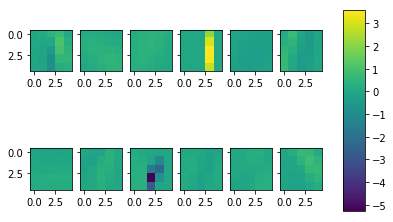


Epoch: 0



Saving..
Best test accuracy: 94.890 	 	  92 s/epoch


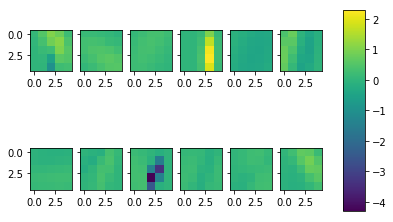


Epoch: 1



Saving..
Best test accuracy: 96.890 	 	  92 s/epoch


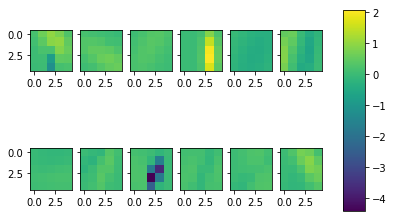


Epoch: 2



Saving..
Best test accuracy: 97.620 	 	  92 s/epoch


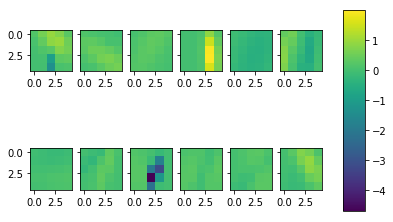


Epoch: 3



Saving..
Best test accuracy: 97.760 	 	  93 s/epoch


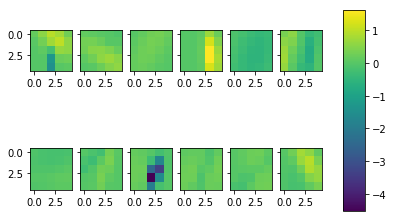


Epoch: 4



Saving..
Best test accuracy: 97.970 	 	  92 s/epoch


In [7]:
# Here we look at how the filters evolve. 
# We first plot the first 6 kernels of each conv layer an then we train one iteration
best_acc = 0  # best test accuracy
latest = datetime.now()
for epoch in range(start_epoch, start_epoch+5):
    old = latest
    net.show_filters(num=6)
    train(epoch)
    test(epoch)
    latest  = datetime.now()
    print('Best test accuracy: {:.3f} \t \t {:3d} s/epoch'.format(best_acc, (latest - old).seconds))
    

In [8]:
# Model
print('==> Building model..')
net = LeNet(in_channels=1)
net = net.to(device)
#if device == 'cuda':
#    net = torch.nn.DataParallel(net)
#    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

==> Building model..


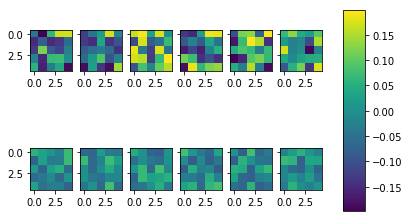


Epoch: 0



Saving..
Best test accuracy: 95.170 	 	  22 s/epoch


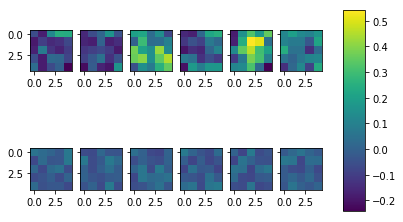


Epoch: 1



Saving..
Best test accuracy: 97.650 	 	  22 s/epoch


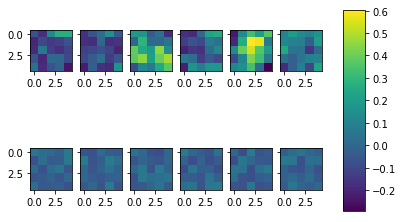


Epoch: 2



Saving..
Best test accuracy: 98.090 	 	  22 s/epoch


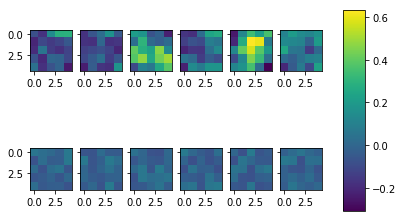


Epoch: 3



Saving..
Best test accuracy: 98.540 	 	  22 s/epoch


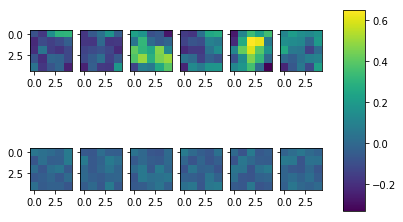


Epoch: 4


In [ ]:
best_acc = 0  # best test accuracy
latest = datetime.now()
for epoch in range(start_epoch, start_epoch+5):
    old = latest
    net.show_filters(num=6)
    train(epoch)
    test(epoch)
    latest  = datetime.now()
    print('Best test accuracy: {:.3f} \t \t {:3d} s/epoch'.format(best_acc, (latest - old).seconds))
    